In [1]:
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools
%matplotlib inline
%load_ext autoreload
%autoreload 2
import random
import pdb
# from multiprocessing import Process, Manager
# from multiprocessing import set_start_method

In [2]:
import sys
sys.path.insert(0, '/home/nkotelevskii/github/corrected_l2hmc/l2hmc_pytorch/l2hmc/utils/')

In [3]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device = "cpu"
device

'cpu'

In [4]:
from func_utils_pt import acl_spectrum, ESS

In [5]:
from distributions_pt import Gaussian
from layers_pt import Net
from dynamics_pt import Dynamics
from sampler_pt import propose
from notebook_utils_pt import get_hmc_samples

In [6]:
network = Net

In [7]:
x_dim = 2
mu = np.zeros(2,)
mu = torch.tensor(mu).to(device)
cov = np.array([[50.05, -49.95], [-49.95, 50.05]])
cov = torch.tensor(cov).to(device)

distribution = Gaussian(mu, cov, device=device)
dynamics = Dynamics(x_dim, distribution.get_energy_function(), T=10, eps=0.1, net_factory=network, device=device)

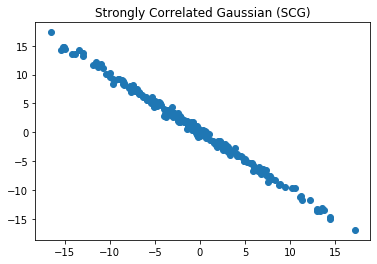

In [8]:
S = distribution.get_samples(200)
plt.title('Strongly Correlated Gaussian (SCG)')
plt.scatter(S[:, 0], S[:, 1])
plt.show()

In [9]:
n_steps = 5000
n_samples = 200
scale = torch.tensor(0.1, device=device)

In [10]:
optim = Adam(dynamics.parameters())

In [11]:
# [p for p in dynamics.parameters()]

In [12]:
dynamics.alpha

Parameter containing:
tensor(0.1000, requires_grad=True)

In [13]:
scheduler = StepLR(optim, step_size=1000, gamma=0.96)

def criterion(v1, v2):
    return scale * (torch.mean(1.0 / v1) + torch.mean(1.0 / v2)) + (-torch.mean(v1) - torch.mean(v2)) / scale

for t in tqdm(range(n_steps)):    
    if(t==0):
        x = torch.randn(n_samples, x_dim, dtype=torch.float32, device=device)
    else:
        x = output[0]

    z = torch.randn_like(x, dtype=torch.float32, device=device)

    optim.zero_grad()
    Lx, _, px, output = propose(x, dynamics, do_mh_step=True, device=device)
    Lz, _, pz, _ = propose(z, dynamics, do_mh_step=False, device=device)

    v1 = (torch.sum((x - Lx)**2, dim=1) * px) + torch.tensor(1e-4, dtype=torch.float32, device=device)
    v2 = (torch.sum((z - Lz)**2, dim=1) * pz) + torch.tensor(1e-4, dtype=torch.float32, device=device)
    scale = torch.tensor(0.1, dtype=torch.float32, device=device)

    loss = criterion(v1, v2)
    loss.backward()

    optim.step()
#     pdb.set_trace()

    if t % 100 == 0:
        current_lr = None
        for param_group in optim.param_groups:
            current_lr = param_group['lr']
        print ('Step: %d / %d, Loss: %.2e, Acceptance sample: %.2f, LR: %.5f' % (t, n_steps, loss.item(), np.mean(px.cpu().detach().numpy()), current_lr))
    scheduler.step()
    optim.zero_grad()

  0%|          | 1/5000 [00:00<20:55,  3.98it/s]

Step: 0 / 5000, Loss: 1.24e+03, Acceptance sample: 0.09, LR: 0.00100


  2%|▏         | 101/5000 [00:25<20:55,  3.90it/s]

Step: 100 / 5000, Loss: -1.09e+02, Acceptance sample: 0.45, LR: 0.00100


  4%|▍         | 201/5000 [00:50<19:43,  4.05it/s]

Step: 200 / 5000, Loss: -1.05e+03, Acceptance sample: 0.36, LR: 0.00100


  6%|▌         | 301/5000 [01:15<18:16,  4.28it/s]

Step: 300 / 5000, Loss: -3.16e+03, Acceptance sample: 0.19, LR: 0.00100


  8%|▊         | 401/5000 [01:41<19:54,  3.85it/s]

Step: 400 / 5000, Loss: -3.33e+03, Acceptance sample: 0.21, LR: 0.00100


 10%|█         | 501/5000 [02:06<19:17,  3.89it/s]

Step: 500 / 5000, Loss: -4.45e+03, Acceptance sample: 0.27, LR: 0.00100


 12%|█▏        | 601/5000 [02:31<17:55,  4.09it/s]

Step: 600 / 5000, Loss: -5.24e+03, Acceptance sample: 0.24, LR: 0.00100


 14%|█▍        | 701/5000 [02:57<17:40,  4.06it/s]

Step: 700 / 5000, Loss: -6.66e+03, Acceptance sample: 0.28, LR: 0.00100


 16%|█▌        | 801/5000 [03:22<17:01,  4.11it/s]

Step: 800 / 5000, Loss: -7.27e+03, Acceptance sample: 0.33, LR: 0.00100


 18%|█▊        | 901/5000 [03:47<17:16,  3.95it/s]

Step: 900 / 5000, Loss: -7.99e+03, Acceptance sample: 0.30, LR: 0.00100


 20%|██        | 1001/5000 [04:13<17:49,  3.74it/s]

Step: 1000 / 5000, Loss: -7.22e+03, Acceptance sample: 0.31, LR: 0.00096


 22%|██▏       | 1101/5000 [04:38<16:11,  4.01it/s]

Step: 1100 / 5000, Loss: -8.07e+03, Acceptance sample: 0.34, LR: 0.00096


 24%|██▍       | 1201/5000 [05:03<16:26,  3.85it/s]

Step: 1200 / 5000, Loss: -7.28e+03, Acceptance sample: 0.37, LR: 0.00096


 26%|██▌       | 1301/5000 [05:29<16:03,  3.84it/s]

Step: 1300 / 5000, Loss: -7.74e+03, Acceptance sample: 0.37, LR: 0.00096


 28%|██▊       | 1401/5000 [05:54<14:21,  4.18it/s]

Step: 1400 / 5000, Loss: -8.11e+03, Acceptance sample: 0.32, LR: 0.00096


 30%|███       | 1501/5000 [06:18<14:28,  4.03it/s]

Step: 1500 / 5000, Loss: -8.26e+03, Acceptance sample: 0.36, LR: 0.00096


 32%|███▏      | 1601/5000 [06:43<14:45,  3.84it/s]

Step: 1600 / 5000, Loss: -9.43e+03, Acceptance sample: 0.38, LR: 0.00096


 34%|███▍      | 1701/5000 [07:08<13:56,  3.94it/s]

Step: 1700 / 5000, Loss: -9.45e+03, Acceptance sample: 0.34, LR: 0.00096


 36%|███▌      | 1801/5000 [07:33<13:25,  3.97it/s]

Step: 1800 / 5000, Loss: -7.98e+03, Acceptance sample: 0.41, LR: 0.00096


 38%|███▊      | 1901/5000 [07:58<12:20,  4.19it/s]

Step: 1900 / 5000, Loss: -7.94e+03, Acceptance sample: 0.35, LR: 0.00096


 40%|████      | 2001/5000 [08:24<12:40,  3.95it/s]

Step: 2000 / 5000, Loss: -8.85e+03, Acceptance sample: 0.40, LR: 0.00092


 42%|████▏     | 2101/5000 [08:49<12:46,  3.78it/s]

Step: 2100 / 5000, Loss: -9.83e+03, Acceptance sample: 0.38, LR: 0.00092


 44%|████▍     | 2201/5000 [09:15<11:24,  4.09it/s]

Step: 2200 / 5000, Loss: -9.44e+03, Acceptance sample: 0.38, LR: 0.00092


 46%|████▌     | 2301/5000 [09:40<10:58,  4.10it/s]

Step: 2300 / 5000, Loss: -8.79e+03, Acceptance sample: 0.37, LR: 0.00092


 48%|████▊     | 2401/5000 [10:05<10:46,  4.02it/s]

Step: 2400 / 5000, Loss: -8.98e+03, Acceptance sample: 0.35, LR: 0.00092


 50%|█████     | 2501/5000 [10:31<10:18,  4.04it/s]

Step: 2500 / 5000, Loss: -8.47e+03, Acceptance sample: 0.37, LR: 0.00092


 52%|█████▏    | 2601/5000 [10:56<10:29,  3.81it/s]

Step: 2600 / 5000, Loss: -9.80e+03, Acceptance sample: 0.30, LR: 0.00092


 54%|█████▍    | 2701/5000 [11:21<09:48,  3.90it/s]

Step: 2700 / 5000, Loss: -9.70e+03, Acceptance sample: 0.34, LR: 0.00092


 56%|█████▌    | 2801/5000 [11:47<09:08,  4.01it/s]

Step: 2800 / 5000, Loss: -8.06e+03, Acceptance sample: 0.33, LR: 0.00092


 58%|█████▊    | 2901/5000 [12:13<08:49,  3.96it/s]

Step: 2900 / 5000, Loss: -9.08e+03, Acceptance sample: 0.37, LR: 0.00092


 60%|██████    | 3001/5000 [12:38<08:10,  4.07it/s]

Step: 3000 / 5000, Loss: -9.24e+03, Acceptance sample: 0.34, LR: 0.00088


 62%|██████▏   | 3101/5000 [13:03<08:05,  3.91it/s]

Step: 3100 / 5000, Loss: -9.59e+03, Acceptance sample: 0.44, LR: 0.00088


 64%|██████▍   | 3201/5000 [13:28<07:21,  4.07it/s]

Step: 3200 / 5000, Loss: -9.14e+03, Acceptance sample: 0.43, LR: 0.00088


 66%|██████▌   | 3301/5000 [13:54<07:38,  3.71it/s]

Step: 3300 / 5000, Loss: -9.52e+03, Acceptance sample: 0.44, LR: 0.00088


 68%|██████▊   | 3401/5000 [14:19<06:09,  4.32it/s]

Step: 3400 / 5000, Loss: -1.07e+04, Acceptance sample: 0.45, LR: 0.00088


 70%|███████   | 3501/5000 [14:44<06:07,  4.08it/s]

Step: 3500 / 5000, Loss: -8.16e+03, Acceptance sample: 0.39, LR: 0.00088


 72%|███████▏  | 3601/5000 [15:08<05:46,  4.04it/s]

Step: 3600 / 5000, Loss: -9.21e+03, Acceptance sample: 0.35, LR: 0.00088


 74%|███████▍  | 3701/5000 [15:33<05:24,  4.00it/s]

Step: 3700 / 5000, Loss: -1.01e+04, Acceptance sample: 0.40, LR: 0.00088


 76%|███████▌  | 3801/5000 [15:57<04:14,  4.72it/s]

Step: 3800 / 5000, Loss: -1.01e+04, Acceptance sample: 0.41, LR: 0.00088


 78%|███████▊  | 3901/5000 [16:18<04:01,  4.56it/s]

Step: 3900 / 5000, Loss: -1.00e+04, Acceptance sample: 0.42, LR: 0.00088


 80%|████████  | 4001/5000 [16:38<03:28,  4.79it/s]

Step: 4000 / 5000, Loss: -8.47e+03, Acceptance sample: 0.38, LR: 0.00085


 82%|████████▏ | 4102/5000 [16:59<02:54,  5.13it/s]

Step: 4100 / 5000, Loss: -8.74e+03, Acceptance sample: 0.38, LR: 0.00085


 84%|████████▍ | 4201/5000 [17:19<02:41,  4.95it/s]

Step: 4200 / 5000, Loss: -1.03e+04, Acceptance sample: 0.39, LR: 0.00085


 86%|████████▌ | 4302/5000 [17:39<02:17,  5.06it/s]

Step: 4300 / 5000, Loss: -9.02e+03, Acceptance sample: 0.37, LR: 0.00085


 88%|████████▊ | 4402/5000 [17:59<01:56,  5.12it/s]

Step: 4400 / 5000, Loss: -9.63e+03, Acceptance sample: 0.37, LR: 0.00085


 90%|█████████ | 4502/5000 [18:18<01:37,  5.09it/s]

Step: 4500 / 5000, Loss: -1.02e+04, Acceptance sample: 0.42, LR: 0.00085


 92%|█████████▏| 4602/5000 [18:38<01:17,  5.12it/s]

Step: 4600 / 5000, Loss: -8.53e+03, Acceptance sample: 0.44, LR: 0.00085


 94%|█████████▍| 4702/5000 [18:58<00:59,  5.02it/s]

Step: 4700 / 5000, Loss: -1.04e+04, Acceptance sample: 0.36, LR: 0.00085


 96%|█████████▌| 4802/5000 [19:18<00:39,  5.05it/s]

Step: 4800 / 5000, Loss: -1.05e+04, Acceptance sample: 0.41, LR: 0.00085


 98%|█████████▊| 4902/5000 [19:38<00:18,  5.17it/s]

Step: 4900 / 5000, Loss: -9.82e+03, Acceptance sample: 0.39, LR: 0.00085


100%|██████████| 5000/5000 [19:57<00:00,  5.02it/s]


In [14]:
dynamics.alpha

Parameter containing:
tensor(0.1620, requires_grad=True)

In [15]:
length_of_chains = 2000

In [16]:
samples = torch.tensor(distribution.get_samples(n=n_samples), dtype=torch.float32, device=device)
final_samples = []

samples_ = samples
with torch.no_grad():
    for t in tqdm(range(length_of_chains)):
        final_samples.append(samples_.cpu().numpy())
        _, _, _, samples_ = propose(samples_, dynamics, do_mh_step=True, trainable=False)
        samples_ = samples_[0].detach()

100%|██████████| 2000/2000 [01:01<00:00, 32.55it/s]


In [17]:
L2HMC_samples = np.array(final_samples)
with torch.no_grad():
    HMC_samples_1 = get_hmc_samples(2, 0.1, distribution.get_energy_function(), steps=length_of_chains, samples=samples)
    HMC_samples_2 = get_hmc_samples(2, 0.15, distribution.get_energy_function(), steps=length_of_chains, samples=samples)
    HMC_samples_3 = get_hmc_samples(2, 0.2, distribution.get_energy_function(), steps=length_of_chains, samples=samples)

100%|██████████| 2000/2000 [00:18<00:00, 109.28it/s]


In [18]:
L2HMC_samples.shape

(2000, 200, 2)

In [19]:
HMC_samples_1.shape

(2000, 200, 2)

In [20]:
# from func_utils_pt import acl_spectrum, ESS

In [21]:
scale = np.sqrt(np.trace(cov.cpu().detach().numpy()))
L2HMC = acl_spectrum(L2HMC_samples, scale=scale)
HMC1 = acl_spectrum(HMC_samples_1, scale=scale)
HMC2 = acl_spectrum(HMC_samples_2, scale=scale)
HMC3 = acl_spectrum(HMC_samples_3, scale=scale)

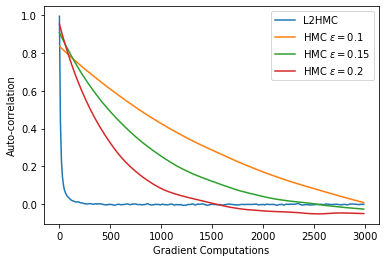

In [22]:
points_to_plot = np.min([300, length_of_chains - 1])
xaxis = 10 * np.arange(points_to_plot)
plt.plot(xaxis, L2HMC[:points_to_plot], label='L2HMC')
plt.plot(xaxis, HMC1[:points_to_plot], label='HMC $\epsilon=0.1$')
plt.plot(xaxis, HMC2[:points_to_plot], label='HMC $\epsilon=0.15$')
plt.plot(xaxis, HMC3[:points_to_plot], label='HMC $\epsilon=0.2$')
plt.ylabel('Auto-correlation')
plt.xlabel('Gradient Computations')
plt.legend()
plt.show()

In [23]:
# print('ESS L2HMC: %.2e -- ESS HMC: %.2e -- Ratio: %d' % (ESS(L2HMC), ESS(HMC2), ESS(L2HMC) / ESS(HMC2)))

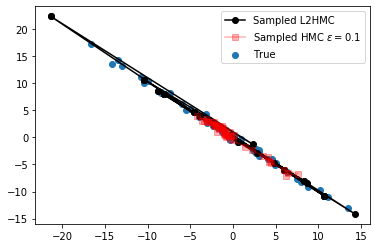

In [24]:
num = -4
points_to_plot = np.min([50, length_of_chains - 1])

plt.scatter(S[:points_to_plot, 0], S[:points_to_plot, 1], label='True')
plt.plot(L2HMC_samples[:points_to_plot, num, 0], L2HMC_samples[:points_to_plot, num, 1], label='Sampled L2HMC', color='black', marker='o')
plt.plot(HMC_samples_2[:points_to_plot, num, 0], HMC_samples_2[:points_to_plot, num, 1], label='Sampled HMC $\epsilon=0.1$', color='red', marker='s', alpha=0.3)
plt.legend()
plt.show()